## CSC Updater Analysis

This code was used to run many runs of the CSC updater on many states, in order to visualize its performance. 

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

import model
import verifier
import cscUpdater
import run_demo_updates

import importlib as imp

import acsDataParallel

import warnings
warnings.filterwarnings('ignore')

Setting our global variables

In [2]:
states = ['NY', 'OR', 'CA', 'MA', 'TX', 'FL', 'OK', 'WI', 'PA', 'MO', 'NV', 'WA', 'OH']
demo_errs_by_state = []
test_errs_by_state = []

Looping through all the states, run a CSC updater on each and record the errors that the resulting model achieved on various demographic groups

In [3]:
imp.reload(model)
for state in states:
    print("Running on %s" %state)
    test_size = 0.2 #train-test split

    acs_task = 'income' # options: employment, income, public_coverage, mobility, and travel_time.
    acs_year = 2016 # 2014-2018
    acs_states = [state] # can be any list of state abbreviations.
    acs_horizon='1-Year' # 1-Year or 5-Year
    acs_survey='person' # 'person' or 'household'

    # for subsampling rows: can specify first and last of data to be pulled. currently pulling everything.
    row_start = 0 
    row_end = -1

    # for subsampling columns. note: can only subsample consecutive columns with folktables
    col_start=0
    col_end=-1
    
    print("Getting data")
    [train_x, train_y, test_x, test_y, demo_group_functions, demo_group_indicators, min_age, mid_age] = acsDataParallel.get_data(
            test_size, acs_task, acs_year, acs_states,acs_horizon=acs_horizon, acs_survey=acs_survey, row_start = row_start, 
            row_end = row_end, col_start=col_start, col_end=col_end)

    print("Training initial model")
    initial_model = DecisionTreeClassifier(max_depth = 1, random_state=0)
    initial_model.fit(train_x, train_y)

    def verify_size(x, group):
        # helper function that checks that the discovered group isn't too small to run on
        g_indices = group(x)
        if g_indices.sum() == 0:
            return False
        else:
            return True

    def run_updates(n_rounds):
        # build the initial model
        mod = model.PointerDecisionList(initial_model.predict, [])
        mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
        mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))

        for j in range(n_rounds):
            print(j)
            # get the predicted ys for the current model
            pred_y = np.array(mod.predict(train_x),dtype=bool)
            # train the cost regressions
            [r0, r1, _] = cscUpdater.training_r0_r1(train_x, train_y, pred_y)
            # generate your g_ and h
            g_ = cscUpdater.g_gen(r0, r1)
            h = cscUpdater.h_gen(r0, r1)

            # run a check to see if the g_ and h are a) too small or b) don't improve compared to the current model
            size_check = verify_size(test_x, g_)
            if size_check:
                improvement_check = verifier.is_proposed_group_good_csc(mod, test_x, test_y, h, g_)
            else:
                print("Group discovered not contained in test set, quitting update process")
                break

            # if they pass the check, run the update
            if improvement_check:
                # run the update
                cscUpdater.iterative_update(mod, h, g_, train_x, train_y, test_x, test_y, "g_%s" % j)

            # otherwise stop running
            else:
                print("Proposed group does not improve model, quitting update process")
                break

        return [mod, mod.test_errors, mod.train_errors]

    num_rounds = 10
    print("running updates")
    [f, test_errors, train_errors] = run_updates(num_rounds)
    
    test_errs_by_state.append(test_errors)

    print("calculating demo errors")
    demo_errs = []
    i = 0
    for g in [lambda x: np.ones(len(x),dtype=bool)] + demo_group_functions:
        indices = g(test_x)
        ys = test_y[indices]
        if len(ys) > 0:
            demo_errs.append(cscUpdater.all_group_errors(f, g, test_x, test_y))
        else:
            demo_errs.append([-1])
        i+=1
    demo_errs_by_state.append(demo_errs)
    print("........................")

Running on NY
Getting data
Training initial model
running updates
0
Error of current model on proposed group: 0.6665945009742369
Error of h trained on proposed group: 0.3334054990257631
1
Error of current model on proposed group: 0.5450367647058824
Error of h trained on proposed group: 0.4540441176470589
2
Error of current model on proposed group: 0.5222672064777327
Error of h trained on proposed group: 0.46963562753036436
3
Error of current model on proposed group: 0.3707865168539326
Error of h trained on proposed group: 0.550561797752809
Proposed group does not improve model, quitting update process
calculating demo errors
........................
Running on OR
Getting data
Training initial model
running updates
0
Error of current model on proposed group: 0.6795005202913631
Error of h trained on proposed group: 0.3204994797086368
1
Error of current model on proposed group: 0.6016949152542372
Error of h trained on proposed group: 0.35593220338983056
2
Error of current model on propose

Save the output to npy files:

In [4]:
np.save("demo_errs_by_state.npy", demo_errs_by_state, allow_pickle=True)
np.save("test_errs_by_state.npy", test_errs_by_state, allow_pickle=True)

Grab the demographic errors from only the last round of updates for every state:

In [5]:
last_round_errs = [[demo_errs_by_state[j][i][-1] for i in range(len(demo_errs_by_state[j]))] for j in range(len(demo_errs_by_state))]

To produce the plot in the paper, we wanted to compare the performance of the CSC updater to a PDL where each update is a (g,h) pair trained directly on a demographic group. So, we have to generate this PDL, which we do below:

In [6]:
trained_demo_errs_by_state = []
test_size, demo_group_functions, demo_group_indicators = None, [], []

for state in states:

    acs_task = 'employment' # options: employment, income, public_coverage, mobility, and travel_time.
    acs_year = 2016 # 2014-2018
    acs_states = [state] # can be any list of state abbreviations.
    acs_horizon='1-Year' # 1-Year or 5-Year
    acs_survey='person' # 'person' or 'household'

    # for subsampling rows: can specify first and last of data to be pulled. currently pulling everything.
    row_start = 0 
    row_end = -1

    # for subsampling columns. note: can only subsample consecutive columns with current implementation (not by me, this was in the template code)
    col_start=0
    col_end=-1

    print("getting data")
    [train_x, train_y, test_x, test_y, demo_group_functions, demo_group_indicators, min_age, mid_age] = acsDataParallel.get_data(
            test_size, acs_task, acs_year, acs_states,acs_horizon=acs_horizon, acs_survey=acs_survey, row_start = row_start, 
            row_end = row_end, col_start=col_start, col_end=col_end)
    
    print("training initial model")
    initial_model = DecisionTreeClassifier(max_depth = 1, random_state=0) #setting random state for replicability
    initial_model.fit(train_x, train_y)
    
    [demo_update_test_errors, demo_update_train_errors] = run_demo_updates.updater_wrapper(initial_model, demo_group_functions, demo_group_indicators, 
                                 test_x, test_y, train_x, train_y,
                                 classifier = "Decision Tree", dt_depth=10)

    trained_demo_errs_by_state.append(demo_update_test_errors)

getting data
training initial model
Building initial model
Running on group 1/11
Group running on Some Other Race
Error of current model on proposed group: 0.23168908819133038
Error of h trained on proposed group: 0.1756352765321375
Running iterative update for group: Some Other Race
Model groups prior to update: 
['Total']
Group errors on test set prior to update (over all groups)
[0.32448089 0.23168909 0.18868468 0.33501418 0.27951636 0.34946913
 0.49226068 0.29755043 0.32965718 0.32498761 0.23970613 0.3438914 ]
Group errors after new group has been prepended to PDL:
[0.32295108717823195, 0.1756352765321375]
Group Weights:
[1.0, 0.027291641169991433]
No repairs needed.
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White', 'Asian', 'Middle', 'Two or More Races']
[0.32295109 0.17563

Running iterative update for group: White
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male']
Group errors on test set prior to update (over all groups)
[0.17690613 0.16591928 0.13251138 0.18342263 0.19061166 0.19559575
 0.21244302 0.15676386 0.17295405 0.19459593 0.18212882 0.1719457 ]
Group errors after new group has been prepended to PDL:
[0.17666136335821814, 0.1659192825112108, 0.13124387855044073, 0.1834226284273558, 0.19061166429587484, 0.19524184034604797, 0.21224264890046585, 0.15663671808781154, 0.17260393873085345]
Group Weights:
[1.0, 0.027291641169991433, 0.35403663362297555, 0.12944152082568433, 0.05735732060539306, 0.518704360951332, 0.40719210214987966, 0.48129563904866807, 0.6991188349039286]
No repairs needed.
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Y

Running iterative update for group: Female
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander']
Group errors on test set prior to update (over all groups)
[0.35243866 0.16400911 0.13051415 0.23428571 0.20454545 0.39605911
 0.59578947 0.30809295 0.37115429 0.28534704 0.22834331 0.35353535]
Group errors after new group has been prepended to PDL:
[0.2588656004768054, 0.16400911161731202, 0.1277760876178886, 0.24571428571428566, 0.19999999999999996, 0.2104433497536946]
Group Weights:
[1.0, 0.04360782755537896, 0.3265123671401609, 0.01738353034667726, 0.021853581007251415, 0.5041223800536406]
Repaired Nodes:
[['Black or African American', 3]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female',

Running iterative update for group: Young
Model groups prior to update: 
['Total', 'Some Other Race']
Group errors on test set prior to update (over all groups)
[0.33786127 0.1677116  0.1622881  0.42525338 0.27794773 0.38449557
 0.56546689 0.29021505 0.35613146 0.33137543 0.25936962 0.39297386]
Group errors after new group has been prepended to PDL:
[0.3255858481634737, 0.15897895208240032, 0.1292987621851862]
Group Weights:
[1.0, 0.04750608984246189, 0.3721026710208597]
No repairs needed.
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White', 'Asian', 'Middle', 'Two or More Races']
[0.32558585 0.15897895 0.12929876 0.39717061 0.26343851 0.37616031
 0.56546689 0.27391398 0.34657077 0.31403398 0.25936962 0.38071895]
.....................................................
Running on grou

Running iterative update for group: Middle
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male']
Group errors on test set prior to update (over all groups)
[nan nan nan nan nan nan nan nan nan nan nan nan]
Group errors after new group has been prepended to PDL:
[0.1836419917241966, 0.15405284370801609, 0.1290986535547869, 0.18095439189189189, 0.17987938117297442, 0.21465406554547561, 0.22334592767250927, 0.15195698924731182, 0.20506148487010534]
Group Weights:
[1.0, 0.04750608984246189, 0.3721026710208597, 0.05037815528300482, 0.12170111372315416, 0.5053665074620515, 0.3744428724909317, 0.49463349253794847, 0.2534544564882086]
Repaired Nodes:
[['Some Other Race', 7]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native Ame

Running iterative update for group: Male
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old']
Group errors on test set prior to update (over all groups)
[0.18128689 0.16472868 0.14676097 0.18087121 0.17948718 0.1900402
 0.21831086 0.17187125 0.18016611 0.20289855 0.16982072 0.26190476]
Group errors after new group has been prepended to PDL:
[0.17700497627589395, 0.16860465116279066, 0.14483202057547018, 0.17613636363636365, 0.18131868131868134, 0.19004019651630188, 0.22086586231369765, 0.1629834254143646]
Group Weights:
[1.0, 0.029857655363962503, 0.3599699108899433, 0.06110403888438838, 0.03159356555954172, 0.5182270570535817, 0.4076495775951857, 0.48177294294641826]
Repaired Nodes:
[['Some Other Race', 6], ['Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 6], ['Old', 6]]
Group errors of every group, even those not yet introduce

Running iterative update for group: Female
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander']
Group errors on test set prior to update (over all groups)
[0.29216177 0.14709371 0.11777073 0.17976135 0.1743559  0.34478104
 0.51699388 0.23756769 0.3200474  0.27214334 0.23614211 0.31784841]
Group errors after new group has been prepended to PDL:
[0.2227296331368177, 0.14709371293001183, 0.11792939309797701, 0.17464745079807842, 0.1689634511683643, 0.2084283143371326]
Group Weights:
[1.0, 0.025750679659101324, 0.38503833582796226, 0.09855820631090204, 0.05098206921831567, 0.5092097626538779]
Repaired Nodes:
[['Young', 2]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'Wh

Running iterative update for group: Black or African American
Model groups prior to update: 
['Total', 'Some Other Race', 'Young']
Group errors on test set prior to update (over all groups)
[0.38260817 0.15507125 0.11959846 0.34984615 0.24863388 0.42270598
 0.62384725 0.33981684 0.40112951 0.3115657  0.23662812 0.38421053]
Group errors after new group has been prepended to PDL:
[0.3590952506757169, 0.15507124895222124, 0.1193325355670789, 0.17184615384615387]
Group Weights:
[1.0, 0.024244518056374093, 0.3056882150913488, 0.13209502713028634]
No repairs needed.
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White', 'Asian', 'Middle', 'Two or More Races']
[0.35909525 0.15507125 0.11933254 0.17184615 0.24863388 0.40062197
 0.58301944 0.31477903 0.40112951 0.3115657  0.2176545  0.3842105

Running iterative update for group: Asian
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White']
Group errors on test set prior to update (over all groups)
[0.17221127 0.1349539  0.11933254 0.16953846 0.16848816 0.19379601
 0.20392259 0.14917661 0.17222436 0.2147915  0.17790025 0.23157895]
Group errors after new group has been prepended to PDL:
[0.17219094844229477, 0.134953897736798, 0.11860124983379872, 0.16953846153846153, 0.16848816029143898, 0.193638546628351, 0.20426895267783696, 0.14930263821206524, 0.17222436144269027, 0.2140047206923682]
Group Weights:
[1.0, 0.024244518056374093, 0.3056882150913488, 0.13209502713028634, 0.022313898429085294, 0.5162476883370252, 0.46938443717357287, 0.4837523116629748, 0.7916556587477391, 0.02582965838193753]
Repaired Nodes:
[['Old', 8]]
Group errors of every group, even those not yet introduced, 

Running iterative update for group: Old
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female']
Group errors on test set prior to update (over all groups)
[0.24891962 0.17676768 0.12583705 0.17682927 0.17085427 0.21333624
 0.37366046 0.28390829 0.26431127 0.20833333 0.24835372 0.26058632]
Group errors after new group has been prepended to PDL:
[0.19425237683664653, 0.16414141414141414, 0.1258370535714286, 0.1707317073170732, 0.20603015075376885, 0.21159293963826542, 0.2309644670050761]
Group Weights:
[1.0, 0.08556611927398444, 0.38720829732065687, 0.05315471045808125, 0.021499567847882456, 0.4957865168539326, 0.3831028522039758]
Repaired Nodes:
[['Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 5]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African 

Running iterative update for group: Black or African American
Model groups prior to update: 
['Total', 'Some Other Race', 'Young']
Group errors on test set prior to update (over all groups)
[0.30501298 0.1728972  0.12255302 0.31546392 0.22413793 0.33533179
 0.50651141 0.27454471 0.30904204 0.22510823 0.17408907 0.31724138]
Group errors after new group has been prepended to PDL:
[0.3000956153530938, 0.1728971962616822, 0.12214518760195758, 0.16701030927835048]
Group Weights:
[1.0, 0.014615489687201203, 0.334926922551564, 0.033123890178937306]
No repairs needed.
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White', 'Asian', 'Middle', 'Two or More Races']
[0.30009562 0.1728972  0.12214519 0.16701031 0.22413793 0.33206159
 0.50022981 0.26797207 0.30904204 0.22510823 0.16505761 0.3172413

Running iterative update for group: Black or African American
Model groups prior to update: 
['Total', 'Some Other Race', 'Young']
Group errors on test set prior to update (over all groups)
[0.31664467 0.16611842 0.13062059 0.33226398 0.26075269 0.34842652
 0.51222698 0.28298712 0.320856   0.26634383 0.2213667  0.35616438]
Group errors after new group has been prepended to PDL:
[0.3074674712426928, 0.16611842105263153, 0.1320141211445559, 0.19844179651695693]
Group Weights:
[1.0, 0.01910868062103212, 0.33829907599472, 0.06857753472876987]
Repaired Nodes:
[['Young', 2]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White', 'Asian', 'Middle', 'Two or More Races']
[0.30699604 0.16611842 0.13062059 0.19156737 0.26075269 0.3401161
 0.49531964 0.27192131 0.320856   0.26634383 0.21119208 0

Error of current model on proposed group: 0.16558324304803174
Error of h trained on proposed group: 0.11827374503430843
Running iterative update for group: Young
Model groups prior to update: 
['Total', 'Some Other Race']
Group errors on test set prior to update (over all groups)
[0.33596021 0.14920635 0.16558324 0.3870229  0.28275862 0.3568909
 0.54220069 0.31393345 0.33607723 0.33457249 0.22990127 0.3164557 ]
Group errors after new group has been prepended to PDL:
[0.3190362379691234, 0.1523809523809524, 0.11827374503430843]
Group Weights:
[1.0, 0.02034752276984691, 0.3577288288870228]
Repaired Nodes:
[['Some Other Race', 1]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White', 'Asian', 'Middle', 'Two or More Races']
[0.31897164 0.14920635 0.11809317 0.35267176 0.28965517 0.34530

Running iterative update for group: Asian
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male']
Group errors on test set prior to update (over all groups)
[nan nan nan nan nan nan nan nan nan nan nan nan]
Group errors after new group has been prepended to PDL:
[0.16762483043731025, 0.1428571428571429, 0.11737089201877937, 0.167175572519084, 0.2206896551724138, 0.18694885361552027, 0.21584870271959988, 0.14728887710460026, 0.19702602230483268]
Group Weights:
[1.0, 0.02034752276984691, 0.3577288288870228, 0.08461985659841095, 0.009366320005167624, 0.5127575738001421, 0.4132807958142239, 0.4872424261998579, 0.017376138492345455]
Repaired Nodes:
[['Young', 5], ['Old', 7]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native Am

Running iterative update for group: Male
Model groups prior to update: 
['Total', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old']
Group errors on test set prior to update (over all groups)
[0.20011728 0.19161677 0.12291933 0.18813906 0.2        0.22641509
 0.25089993 0.17243455 0.19849088 0.22077922 0.22352941 0.2287234 ]
Group errors after new group has been prepended to PDL:
[0.19278698138102912, 0.12377294067434907, 0.17586912065439675, 0.19199999999999995, 0.2264150943396226, 0.24658027357811374, 0.15738790249774304]
Group Weights:
[1.0, 0.34349802081806186, 0.07169036798123442, 0.07330303474563847, 0.5128280310804867, 0.4072716610467673, 0.48717196891951325]
Repaired Nodes:
[['Young', 3]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific I

Running iterative update for group: Old
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Female']
Group errors on test set prior to update (over all groups)
[0.23756631 0.15450644 0.12278761 0.18489066 0.18810289 0.20864171
 0.34872149 0.26740009 0.24730121 0.22048998 0.22038385 0.27552987]
Group errors after new group has been prepended to PDL:
[0.18915782493368705, 0.15879828326180256, 0.12278761061946908, 0.16500994035785288, 0.21430126251632564, 0.22764340013821704]
Group Weights:
[1.0, 0.051503094606542885, 0.34969053934571176, 0.027796198054818744, 0.507736516357206, 0.39981211317418214]
Repaired Nodes:
[['Some Other Race', 4], ['Female', 4]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White', 'Asian', 'Middle', 'Two or More 

Running iterative update for group: Female
Model groups prior to update: 
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander']
Group errors on test set prior to update (over all groups)
[0.2904929  0.16147309 0.1206045  0.17717206 0.19090909 0.32343124
 0.47431904 0.25617305 0.3095458  0.24319419 0.20390229 0.22727273]
Group errors after new group has been prepended to PDL:
[0.2195387812106142, 0.1515580736543909, 0.12080205452390358, 0.1696763202725724, 0.2090909090909091, 0.1843791722296395]
Group Weights:
[1.0, 0.024048778826174337, 0.344858125830296, 0.09997615560173043, 0.007493953741867357, 0.5102701229689682]
Repaired Nodes:
[['Young', 2], ['Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 4]]
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native A

In [7]:
np.save("trained_demo_errs_by_state.npy", trained_demo_errs_by_state)

In [8]:
trained_demo_errs_by_state_reload = np.load("trained_demo_errs_by_state.npy", allow_pickle=True) 

# Visualizing Performance

The demographic groups were fed into their updater in a random order, so we have to unshuffle them to compare their results to the demographic errors of the CSC process and get rid of the NaNs that are due to a (g,h) pair being rejected.

In [9]:
rng = np.random.default_rng(12346)
r_indices = np.arange(len(demo_group_functions))
rng.shuffle(r_indices)
r_group_functions = [demo_group_functions[i] for i in r_indices]
r_group_indicators = [demo_group_indicators[i] for i in r_indices]
unsorted_indices = np.argsort(r_indices)
unsorted_indices = unsorted_indices + 1 # dealing w addition of the total column
unsorted_indices = np.insert(unsorted_indices, 0, 0, axis=0) 

In [10]:
unrandomized_trained_demo_errs_by_state = []
for state in trained_demo_errs_by_state_reload:
    unrandomized_trained_demo_errs_by_state.append(state[:, unsorted_indices])

In [11]:
final_trained_demo_errs = []
for state in unrandomized_trained_demo_errs_by_state:
    i = len(state) - 1
    while i >= 0:
        if np.isnan(state[i][0]):
            i -=1
        else:
            break
    final_trained_demo_errs.append(state[i])

Next, we have to pull out the demographic errors at the final round of the CSC updates

In [12]:
untrained_demo_errs = np.load("demo_errs_by_state.npy", allow_pickle=True)
stacked_untrained_demo_errs = []
for i in range(len(untrained_demo_errs)):
    stacked_untrained_demo_errs.append(np.stack(untrained_demo_errs[i]))
untrained_demo_errs = stacked_untrained_demo_errs

In [13]:
last_untrained_demo_errs = []
for i in range(len(untrained_demo_errs)):
    last_untrained_demo_errs.append(untrained_demo_errs[i][:,-1])

For our plots, we're interested in the difference between the two, so we calculate that here and then plot!

In [14]:
diffs = []
for i in range(len(final_trained_demo_errs)):
    diffs.append(last_untrained_demo_errs[i] - final_trained_demo_errs[i])

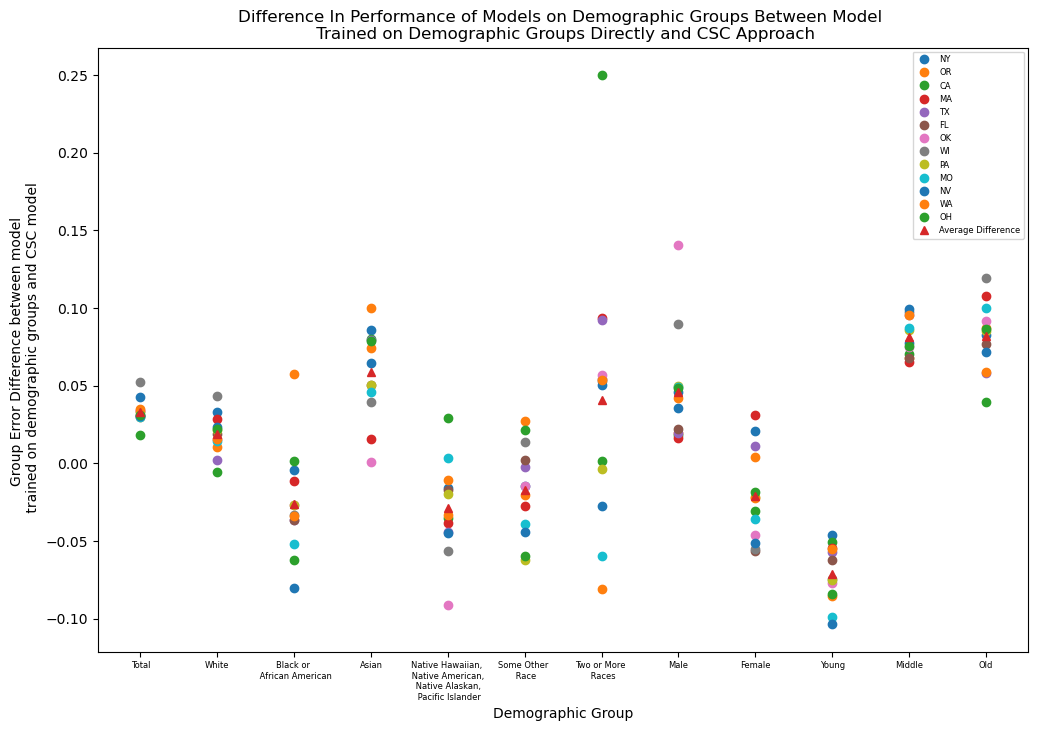

In [15]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k') # make plot bigger

inds = ['Total', 'White', 'Black or \n African American',
 'Asian','Native Hawaiian, \n Native American, \n Native Alaskan, \n Pacific Islander',
 'Some Other \n Race',
 'Two or More \n Races',
 'Male',
 'Female',
 'Young',
 'Middle',
 'Old']
for i in range(len(diffs)):
    plt.plot(inds, diffs[i], '.', label = states[i], markersize=12)
plt.plot(inds, np.average(np.array(diffs), axis=0), '^', markersize=6, label='Average Difference')
plt.legend(fontsize=6, loc="upper right")
plt.xticks(fontsize=6)
plt.xlabel("Demographic Group")
plt.ylabel("Group Error Difference between model \n trained on demographic groups and CSC model")
plt.title("Difference In Performance of Models on Demographic Groups Between Model \n Trained on Demographic Groups Directly and CSC Approach")
plt.savefig("error_diffs.png")

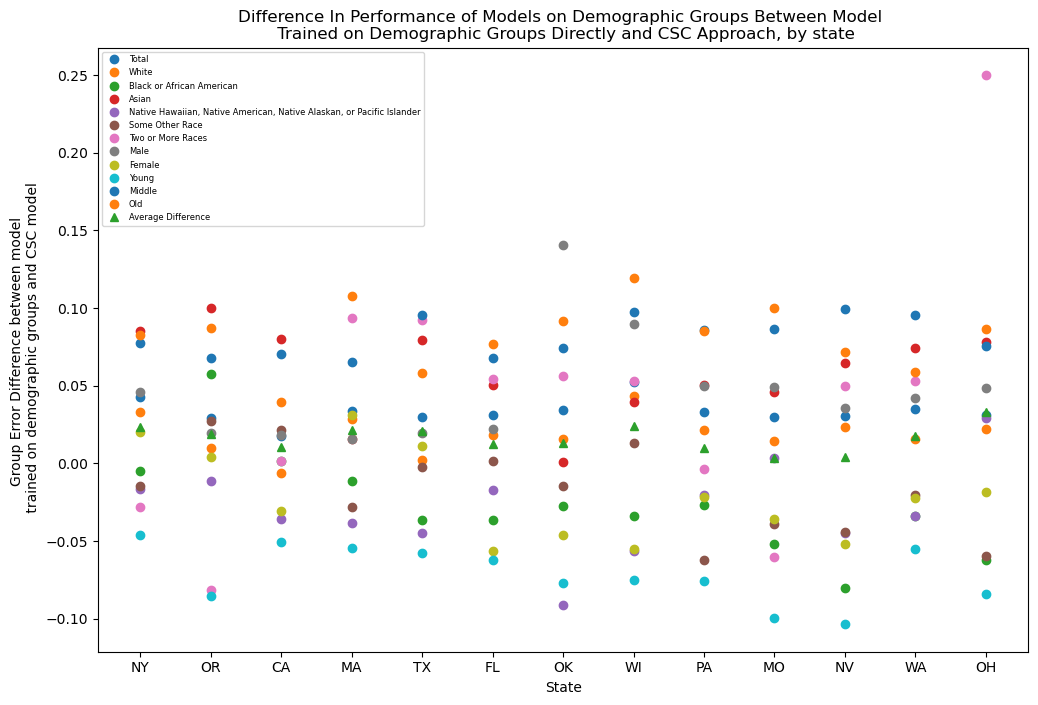

In [16]:
labels = ["Total"] + demo_group_indicators
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k') # make plot bigger
for i in range(len(labels)):
    plt.plot(states, np.array(diffs)[:,i], '.', label=labels[i], markersize=12)
plt.plot(states, np.average(np.array(diffs), axis=1), '^', label='Average Difference', markersize=6)
plt.legend(prop={'size': 6})
plt.title("Difference In Performance of Models on Demographic Groups Between Model \n Trained on Demographic Groups Directly and CSC Approach, by state")
plt.ylabel("Group Error Difference between model \n trained on demographic groups and CSC model")
plt.xlabel('State')
plt.savefig('state_demo_errs.png')

And finally, print out some useful information

In [17]:
print(*(["Total"] + demo_group_indicators), sep = ' & ')
print(*np.average(final_trained_demo_errs, axis=0), sep=' & ')
print(* np.average(last_untrained_demo_errs, axis=0), sep= ' & ')

Total & White & Black or African American & Asian & Native Hawaiian, Native American, Native Alaskan, or Pacific Islander & Some Other Race & Two or More Races & Male & Female & Young & Middle & Old
0.17507101699163174 & 0.19758863746130764 & 0.21682963318100365 & 0.12384508488801507 & 0.17432865443413137 & 0.1824706354201962 & 0.1751122454172434 & 0.1924678259512561 & 0.196333095982078 & 0.1543990149956675 & 0.1517206043022083 & 0.17803703321186698
0.2082060500731755 & 0.2162621074051661 & 0.19026120457775914 & 0.18270448563622965 & 0.14534635212257238 & 0.16549691782515463 & 0.216044435165943 & 0.23830571378431908 & 0.17544972281868712 & 0.08316891622281702 & 0.23326063948359219 & 0.2599623100471075


In [18]:
print(*states[0:7], sep = ' & ')
print(*np.average(final_trained_demo_errs, axis=1), sep=' & ')
print(* np.average(last_untrained_demo_errs, axis=1), sep= ' & ')

NY & OR & CA & MA & TX & FL & OK
0.17785301047071958 & 0.1896256003845298 & 0.1847262456463535 & 0.17469485200311766 & 0.17202573854022526 & 0.17497771339013657 & 0.17176070927810147 & 0.15790193510739856 & 0.17531991756181406 & 0.17254740612082972 & 0.1916275552767626 & 0.18263640374078471 & 0.16902335156888304
0.20102551756127007 & 0.20843372990481732 & 0.19537102295633757 & 0.19630751751900902 & 0.1926427988736041 & 0.1875094766706509 & 0.18490125757217046 & 0.18191028476555338 & 0.18503478860296976 & 0.17623962508503602 & 0.19575932621713757 & 0.20008136155406508 & 0.20212455247677896


In [19]:
print(*(["Total"] + demo_group_indicators), sep = ' & ')
np.average(diffs, axis=0)

Total & White & Black or African American & Asian & Native Hawaiian, Native American, Native Alaskan, or Pacific Islander & Some Other Race & Two or More Races & Male & Female & Young & Middle & Old


array([ 0.03313503,  0.01867347, -0.02656843,  0.0588594 , -0.0289823 ,
       -0.01697372,  0.04093219,  0.04583789, -0.02088337, -0.0712301 ,
        0.08154004,  0.08192528])

In [20]:
np.average(np.array(diffs))

0.016355447743826444

In [21]:
print(labels)
av = np.average(np.array(diffs), axis=0)
for i in range(len(av)):
    print(labels[i], av[i])

['Total', 'White', 'Black or African American', 'Asian', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Some Other Race', 'Two or More Races', 'Male', 'Female', 'Young', 'Middle', 'Old']
Total 0.03313503308154372
White 0.018673469943858493
Black or African American -0.026568428603244505
Asian 0.05885940074821457
Native Hawaiian, Native American, Native Alaskan, or Pacific Islander -0.028982302311558985
Some Other Race -0.016973717595041498
Two or More Races 0.04093218974869956
Male 0.045837887833062925
Female -0.020883373163390874
Young -0.07123009877285048
Middle 0.0815400351813839
Old 0.08192527683524047
